In [1]:
pip install vaderSentiment

     |████████████████████████████████| 125 kB 2.7 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#note: depending on how you installed (e.g., using source code download versus pip install), you may need to import like this:
#from vaderSentiment import SentimentIntensityAnalyzer

import itertools
import json
import string
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text, stop_words
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from string import punctuation
from string import digits
from nltk.corpus import wordnet
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_curve
from sklearn.model_selection import train_test_split
import json
import re
import pandas as pd


def my_custom_preprocessor(doc_string):
    # do all data preprocessing here
    
    # Lower case
    doc_string=doc_string.lower()
    
    # Remove Numbers
    remove_digits = str.maketrans('', '', digits)
    doc_string.translate(remove_digits)
    
    # Convert to tokenized form....
    tokens = nltk.tokenize.word_tokenize(doc_string)
    # Iterate through list of tokens (words) and remove all numbers
    tokens = [word for word in tokens if word.isalpha()]
    # Iterate through list of tokens (words) and stem (shorten) each word
    port_stemmer = PorterStemmer()
    tokens = [port_stemmer.stem(words) for words in tokens ]
    
    ###############################
    #### Lemmatize with pos_tag ###
    ###############################
    
    lemmatizer = WordNetLemmatizer()
    
    # Convert between two different tagging schemes
    def change_tags(penntag):
        morphy_tag = {'NN':'n', 'JJ':'a',
                      'VB':'v', 'RB':'r'}
        try:
            return morphy_tag[penntag[:2]]
        except:
            return 'n'
        
    tokens = [lemmatizer.lemmatize(word.lower(), pos=change_tags(tag)) for word, tag in pos_tag(tokens)]
    
    # Rejoin List of tokens and return that single document-string
    return ' '.join(tokens)


#####################################################
#### Define Custom stop words for CountVectorizer ###
#####################################################

stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

# Run stop_words through the same pre-processor as the document-matrix
# This will apply stemmed/lemmatized stop_woirds to stemmed/lemmatized tokenized document lists
def process_stop_words(stop_word_set):
    doc_string = ' '.join(stop_word_set)
    return my_custom_preprocessor(doc_string).split()


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
tweet_files = [r'../input/gohawkspats/tweets_gohawks.txt', r'../input/gohawkspats/tweets_gopatriots.txt']

go_pats = []
go_hawks = []

analyzer = SentimentIntensityAnalyzer()

#neg, neu, pos, compound

for file in tweet_files:
    with open(file, 'r') as cur_file:
        for line in cur_file:
            json_data = json.loads(line)
            time = json_data['citation_date']
            text = json_data['tweet']['text']
            vader_neg = analyzer.polarity_scores(text)['neg']
            vader_neg = '%.2f'%(float(vader_neg))
            vader_neu = analyzer.polarity_scores(text)['neu']
            vader_neu = '%.2f'%(float(vader_neu))
            vader_pos = analyzer.polarity_scores(text)['pos']
            vader_pos = '%.2f'%(float(vader_pos))
            vader_compound = analyzer.polarity_scores(text)['compound']
            vader_compound = '%.2f'%(float(vader_compound))
            
            if file == r'../input/gohawkspats/tweets_gohawks.txt':
                go_hawks.append((text, time, vader_neg, vader_neu, vader_pos, vader_compound))
            else:
                go_pats.append((text, time, vader_neg, vader_neu, vader_pos, vader_compound))

go_hawks = np.array(go_hawks)
go_pats = np.array(go_pats)
print(go_hawks[:,0])

print("Size of hawks dataset: " +str(go_hawks.shape))
print("Size of patriots dataset: " +str(go_pats.shape))

['I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8'
 'twelfth dogs are ready! #gohawks #dogslife http://t.co/gd3v6vQps5'
 '"Oh no big deal, just NFC West Champs and the number 1 seed again" #Seahawks #GoHawks #12s http://t.co/7NigOjTPz2'
 ...
 'Interview With the Seattle Seahawks Superbowl Champions http://t.co/zuojfZDLZf #Gohawks #superbowlxlviii #NFL #ESPN'
 'If you love Russell Wilson and want to know more about him. http://t.co/6XuXkyFJ9s #Seahawks #NFL #GoHawks'
 "The ultimate broken hearted hangover week from hell (#SB49) is almost over. Listening to the blues still. We'll get'em in #SB50 #GOHAWKS"]
Size of hawks dataset: (169122, 6)
Size of patriots dataset: (23511, 6)


In [4]:
#sid = SentimentIntensityAnalyzer()
#ss = sid.polarity_scores(sentence)['pos']

arr_hawks = np.array(go_hawks)
arr_pats = np.array(go_pats)
print(arr_hawks.shape)
print(arr_pats.shape)
print(arr_pats[:,3])
#tweet, time, neg, neu, pos, comp = 0, 1, 2, 3, 4, 5


pats_df = pd.DataFrame(data=arr_pats,columns=['text','time','vader_neg','vader_neu','vader_pos','vader_compound'])
pats_df
hawks_df = pd.DataFrame(data=arr_hawks,columns=['text','time','vader_neg','vader_neu','vader_pos','vader_compound'])
hawks_df

(169122, 6)
(23511, 6)
['0.86' '0.62' '0.81' ... '0.60' '1.00' '1.00']


,text,time,vader_neg,vader_neu,vader_pos,vader_compound
0,I &lt;3 our defense! #GoHawks http://t.co/U1pc...,1421518778,0.00,0.74,0.26,0.20
1,twelfth dogs are ready! #gohawks #dogslife htt...,1421259536,0.00,0.68,0.32,0.42
2,"""Oh no big deal, just NFC West Champs and the ...",1421468519,0.27,0.57,0.17,-0.55
3,At http://t.co/Vd0RWOeAed -- #Seahawks #12thMA...,1421468497,0.00,1.00,0.00,0.00
4,"Good luck at Michigan, Jim Harbaugh. #GoHawks ...",1421468336,0.00,0.50,0.50,0.71
...,...,...,...,...,...,...
169117,How long to you think that it will be until we...,1423290285,0.00,0.84,0.16,0.60
169118,"#Seahawks all day, everyday!!! #beastmode #LOB...",1423291665,0.00,1.00,0.00,0.00
169119,Interview With the Seattle Seahawks Superbowl ...,1423295642,0.00,0.76,0.24,0.53
169120,If you love Russell Wilson and want to know mo...,1423295796,0.00,0.72,0.28,0.67


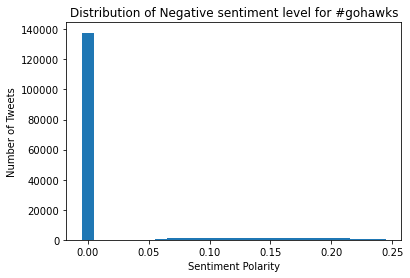

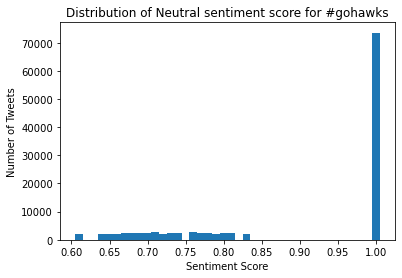

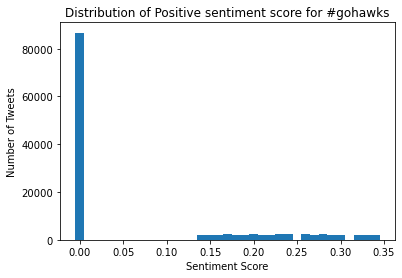

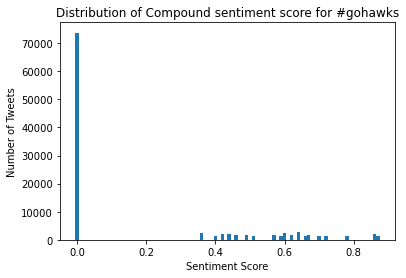

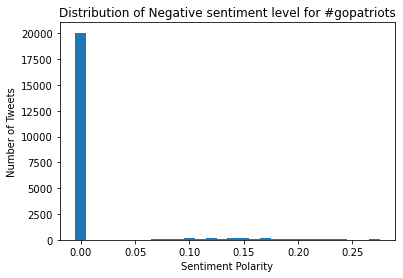

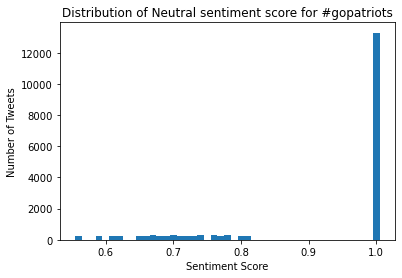

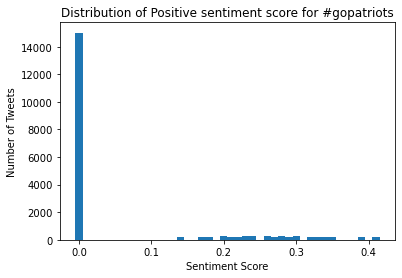

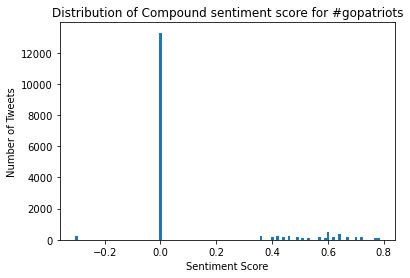

In [5]:
def pick_top_hist(data_array, col):
    
    numeric_data = data_array[:,col].astype(np.float)
    unique_val, unique_count = np.unique(numeric_data, return_counts=True)
    unique_all = np.vstack((unique_val, unique_count)).T
    #sorted_unique = unique_all[np.argsort(unique_all[:,0])]
    sorted_unique = unique_all[unique_all[:,1].argsort()]
    #sort descending
    sorted_unique = sorted_unique[::-1]
    top_values = sorted_unique[:20,:20]
    score = top_values[:,0]
    count = top_values[:,1]
    return score, count



# Plot Labels and Formatting

#plt.xticks(np.arange(-10,100,10))

plt.xlabel("Sentiment Polarity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Negative sentiment level for #gohawks")
top_neg_scores, top_neg_counts = pick_top_hist(arr_hawks,2)
plt.bar(top_neg_scores, top_neg_counts, align='center',width=0.01)
#plt.hist(arr_hawks[:,2], bins='auto')
plt.show()




plt.xlabel("Sentiment Score")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Neutral sentiment score for #gohawks")
top_neu_scores, top_neu_counts = pick_top_hist(arr_hawks,3)
plt.bar(top_neu_scores, top_neu_counts, align='center',width=0.01)
plt.show()




plt.xlabel("Sentiment Score")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Positive sentiment score for #gohawks")
top_pos_scores, top_pos_counts = pick_top_hist(arr_hawks,4)
plt.bar(top_pos_scores, top_pos_counts, align='center',width=0.01)
plt.show()

# Plot Labels and Formatting



plt.xlabel("Sentiment Score")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Compound sentiment score for #gohawks")
top_comp_scores, top_comp_counts = pick_top_hist(arr_hawks,5)
plt.bar(top_comp_scores, top_comp_counts, align='center',width=0.01)
plt.show()


###############################
#patriots

plt.xlabel("Sentiment Polarity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Negative sentiment level for #gopatriots")
top_neg_scores, top_neg_counts = pick_top_hist(arr_pats,2)
plt.bar(top_neg_scores, top_neg_counts, align='center',width=0.01)
plt.show()




plt.xlabel("Sentiment Score")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Neutral sentiment score for #gopatriots")
top_neu_scores, top_neu_counts = pick_top_hist(arr_pats,3)
plt.bar(top_neu_scores, top_neu_counts, align='center',width=0.01)
plt.show()




plt.xlabel("Sentiment Score")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Positive sentiment score for #gopatriots")
top_pos_scores, top_pos_counts = pick_top_hist(arr_pats,4)
plt.bar(top_pos_scores, top_pos_counts, align='center',width=0.01)
plt.show()

# Plot Labels and Formatting



plt.xlabel("Sentiment Score")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Compound sentiment score for #gopatriots")
top_comp_scores, top_comp_counts = pick_top_hist(arr_pats,5)
plt.bar(top_comp_scores, top_comp_counts, align='center',width=0.01)
plt.show()

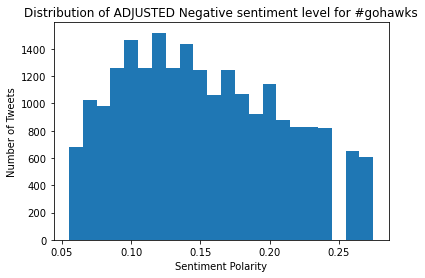

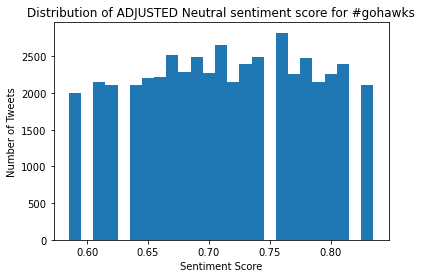

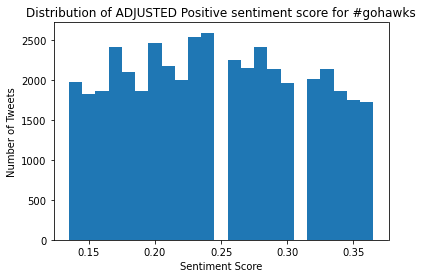

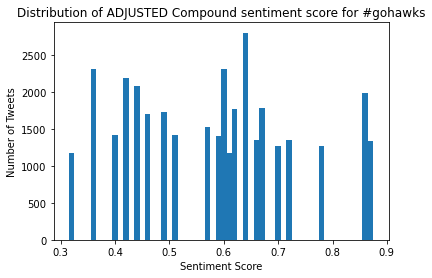

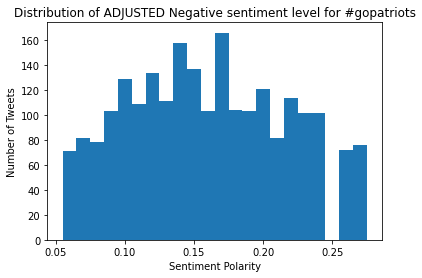

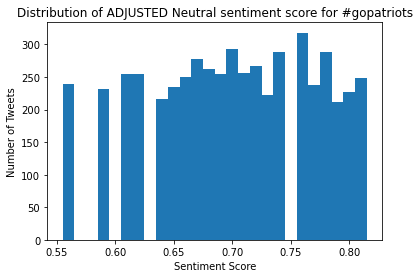

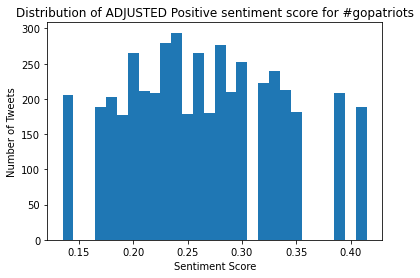

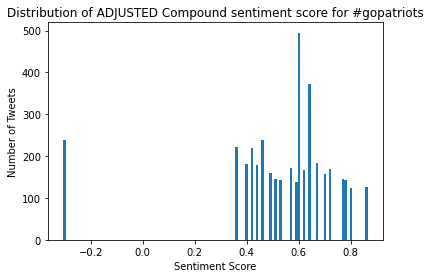

In [6]:
#we see that limitations with VADER means that most comments are neutral, (1.0 neutral, 0 positive, 0 negative)
#in these histograms, let's remove the fully neutral entries



def pick_not_neutral_hist(data_array, col):
    
    numeric_data = data_array[:,col].astype(np.float)
    unique_val, unique_count = np.unique(numeric_data, return_counts=True)
    unique_all = np.vstack((unique_val, unique_count)).T
    #sorted_unique = unique_all[np.argsort(unique_all[:,0])]
    sorted_unique = unique_all[unique_all[:,1].argsort()]
    #sort descending
    sorted_unique = sorted_unique[::-1]
    sorted_unique = np.delete(sorted_unique,0,0)
    top_values = sorted_unique[:21,:21]
    score = top_values[:,0]
    count = top_values[:,1]
    return score, count



# Plot Labels and Formatting

#plt.xticks(np.arange(-10,100,10))

plt.xlabel("Sentiment Polarity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of ADJUSTED Negative sentiment level for #gohawks")
top_neg_scores, top_neg_counts = pick_not_neutral_hist(arr_hawks,2)
plt.bar(top_neg_scores, top_neg_counts, align='center',width=0.01)
#plt.hist(arr_hawks[:,2], bins='auto')
plt.show()




plt.xlabel("Sentiment Score")
plt.ylabel("Number of Tweets")
plt.title("Distribution of ADJUSTED Neutral sentiment score for #gohawks")
top_neu_scores, top_neu_counts = pick_not_neutral_hist(arr_hawks,3)
plt.bar(top_neu_scores, top_neu_counts, align='center',width=0.01)
plt.show()




plt.xlabel("Sentiment Score")
plt.ylabel("Number of Tweets")
plt.title("Distribution of ADJUSTED Positive sentiment score for #gohawks")
top_pos_scores, top_pos_counts = pick_not_neutral_hist(arr_hawks,4)
plt.bar(top_pos_scores, top_pos_counts, align='center',width=0.01)
plt.show()

# Plot Labels and Formatting



plt.xlabel("Sentiment Score")
plt.ylabel("Number of Tweets")
plt.title("Distribution of ADJUSTED Compound sentiment score for #gohawks")
top_comp_scores, top_comp_counts = pick_not_neutral_hist(arr_hawks,5)
plt.bar(top_comp_scores, top_comp_counts, align='center',width=0.01)
plt.show()


###############################
#patriots

plt.xlabel("Sentiment Polarity")
plt.ylabel("Number of Tweets")
plt.title("Distribution of ADJUSTED Negative sentiment level for #gopatriots")
top_neg_scores, top_neg_counts = pick_not_neutral_hist(arr_pats,2)
plt.bar(top_neg_scores, top_neg_counts, align='center',width=0.01)
plt.show()




plt.xlabel("Sentiment Score")
plt.ylabel("Number of Tweets")
plt.title("Distribution of ADJUSTED Neutral sentiment score for #gopatriots")
top_neu_scores, top_neu_counts = pick_not_neutral_hist(arr_pats,3)
plt.bar(top_neu_scores, top_neu_counts, align='center',width=0.01)
plt.show()




plt.xlabel("Sentiment Score")
plt.ylabel("Number of Tweets")
plt.title("Distribution of ADJUSTED Positive sentiment score for #gopatriots")
top_pos_scores, top_pos_counts = pick_not_neutral_hist(arr_pats,4)
plt.bar(top_pos_scores, top_pos_counts, align='center',width=0.01)
plt.show()

# Plot Labels and Formatting



plt.xlabel("Sentiment Score")
plt.ylabel("Number of Tweets")
plt.title("Distribution of ADJUSTED Compound sentiment score for #gopatriots")
top_comp_scores, top_comp_counts = pick_not_neutral_hist(arr_pats,5)
plt.bar(top_comp_scores, top_comp_counts, align='center',width=0.01)
plt.show()

In [7]:
#preprocess the data again to see the time flow


hawks_df = pd.DataFrame(data=arr_hawks,columns=['text','time','vader_neg','vader_neu','vader_pos','vader_compound'])
pats_df = pd.DataFrame(data=arr_pats,columns=['text','time','vader_neg','vader_neu','vader_pos','vader_compound'])

hawks_df
pats_df


,text,time,vader_neg,vader_neu,vader_pos,vader_compound
0,LeGarrette Blount does the Ray Lewis Dance #Th...,1421257541,0.00,0.86,0.14,0.44
1,Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M...,1421275471,0.00,0.62,0.38,0.91
2,With both my father and husband yelling at the...,1421341875,0.05,0.81,0.14,0.51
3,The girls soccer team is ranked the No. 3 team...,1421285189,0.00,1.00,0.00,0.00
4,@patriots Patriots Champions! RT if you agree ...,1421427332,0.00,0.43,0.57,0.80
...,...,...,...,...,...,...
23506,Butler!!!! Yeess!!! Esto si que sería ganar so...,1423083356,0.00,1.00,0.00,0.00
23507,Butler!!!! Yeess!!! Esto si que sería ganar so...,1423097475,0.00,1.00,0.00,0.00
23508,#PatriotsNation sign petition to help sad peop...,1423172815,0.13,0.60,0.27,0.48
23509,RT JomaGh: Comienza el #SUperBowl ¿A quien le ...,1423228689,0.00,1.00,0.00,0.00


In [8]:
pats_df['text'] = pats_df['text'].astype(str)
pats_df['time'] = pats_df['time'].astype(int)
pats_df['vader_neg'] = pats_df['vader_neg'].astype(float)
pats_df['vader_neu'] = pats_df['vader_neu'].astype(float)
pats_df['vader_pos'] = pats_df['vader_pos'].astype(float)
pats_df['vader_compound'] = pats_df['vader_compound'].astype(float)


hawks_df['text'] = hawks_df['text'].astype(str)
hawks_df['time'] = hawks_df['time'].astype(int)
hawks_df['vader_neg'] = hawks_df['vader_neg'].astype(float)
hawks_df['vader_neu'] = hawks_df['vader_neu'].astype(float)
hawks_df['vader_pos'] = hawks_df['vader_pos'].astype(float)
hawks_df['vader_compound'] = hawks_df['vader_compound'].astype(float)


pats_time = np.array(pats_df)
hawks_time = np.array(hawks_df)

Earliest Timestamp in Dataset (Unix Time): 1421222681
Latest Timestamp in Dataset (Unix Time): : 1423304269
Range of Dataset (Time in Hours): 578


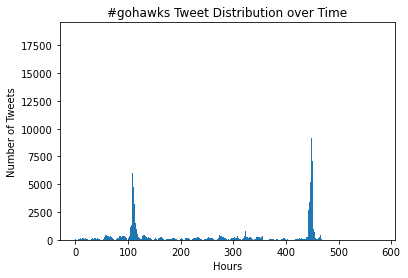

In [9]:
# Order timestamps from Earliest to Latest


time_sorted_hawks = hawks_time[hawks_time[:,1].argsort()]
time_sorted_pats = pats_time[pats_time[:,1].argsort()]


# Calculate the time-range of dataset in hours
earliest_TimeStamp = min(time_sorted_hawks[:,1])
latest_TimeStamp = max(time_sorted_hawks[:,1])
hours_range_in_dataset = round((latest_TimeStamp - earliest_TimeStamp) / 3600)

# Bin each timestamp into an hour-bin:
# Normalize timestamps (minus earliest timestamp)
# Convert to hours (divide by 3600 seconds)
# Keep first Digit (hour-bin) (//1)
tweetHourNumber = ((np.array(time_sorted_hawks[:,1]) - earliest_TimeStamp) / 3600) // 1
plt.hist(tweetHourNumber, bins=hours_range_in_dataset)
plt.title('#gohawks Tweet Distribution over Time')
plt.xlabel('Hours')
plt.ylabel('Number of Tweets')

print(f'Earliest Timestamp in Dataset (Unix Time): {earliest_TimeStamp}')
print(f'Latest Timestamp in Dataset (Unix Time): : {latest_TimeStamp}')
print(f'Range of Dataset (Time in Hours): {hours_range_in_dataset}')


Earliest Timestamp in Dataset (Unix Time): 1421222681
Latest Timestamp in Dataset (Unix Time): : 1423304269
Range of Dataset (Time in Hours): 578


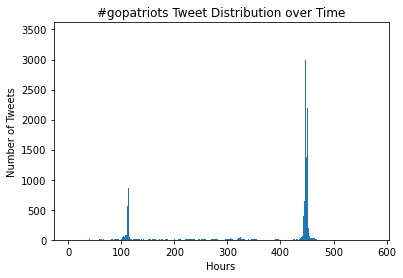

In [10]:
tweetHourNumber = ((np.array(time_sorted_pats[:,1]) - earliest_TimeStamp) / 3600) // 1
plt.hist(tweetHourNumber, bins=hours_range_in_dataset)
plt.title('#gopatriots Tweet Distribution over Time')
plt.xlabel('Hours')
plt.ylabel('Number of Tweets')

print(f'Earliest Timestamp in Dataset (Unix Time): {earliest_TimeStamp}')
print(f'Latest Timestamp in Dataset (Unix Time): : {latest_TimeStamp}')
print(f'Range of Dataset (Time in Hours): {hours_range_in_dataset}')

In [11]:
pos_pats = []
pos_hawks = []
neg_pats = []
neg_hawks = []


analyzer = SentimentIntensityAnalyzer()
#neg, neu, pos, compound
tweet_files = [r'../input/gohawkspats/tweets_gohawks.txt', r'../input/gohawkspats/tweets_gopatriots.txt']

for file in tweet_files:
    with open(file, 'r') as cur_file:
        for line in cur_file:
            json_data = json.loads(line)
            time = json_data['citation_date']
            text = json_data['tweet']['text']
            vader_compound = analyzer.polarity_scores(text)['compound']
            #assign -1, 0, 1 for negative, neutral, and positive          
            
            if file == r'../input/gohawkspats/tweets_gohawks.txt':
                if vader_compound >= 0.2:
                    vader_compound = 1
                    pos_hawks.append((text, time, vader_compound))
                    
                elif 0.2 > vader_compound > -0.2:
                    vader_compound = 0
                    
                else:
                    vader_compound = - 1  
                    neg_hawks.append((text, time, vader_compound))
            
            else:
                if vader_compound >= 0.2:
                    vader_compound = 1
                    pos_pats.append((text, time, vader_compound))

                elif 0.2 > vader_compound > -0.2:
                    vader_compound = 0
                else:
                    vader_compound = - 1 
                    neg_pats.append((text, time, vader_compound))
                
pos_hawks = np.array(pos_hawks)
neg_hawks = np.array(neg_hawks)

pos_pats = np.array(pos_pats)
neg_pats = np.array(neg_pats)

print(neg_hawks[:,2])

['-1' '-1' '-1' ... '-1' '-1' '-1']


In [12]:
print(go_hawks.shape)
print(go_pats.shape)

(169122, 6)
(23511, 6)


In [13]:
print("Number of positive #gohawks tweets: " +str(np.size(pos_hawks[:,2])))
print("Number of negative #gohawks tweets: " +str(np.size(neg_hawks[:,2])))
print("% of #gohawks tweets that were positive: " +str(100* float(np.size(pos_hawks[:,2]) / 169122)))
print("% of #gohawks tweets that were negative: " +str(100* float(np.size(neg_hawks[:,2]) / 169122)))
print("% of non-neutral #gohawks tweets that were positive: " + str(100* 73755 / (73755+16144)))
print("% of non-neutral #gohawks tweets that were positive: " + str(100* 16144 / (73755+16144)))

print("Number of positive #gopatriots tweets: " +str(np.size(pos_pats[:,2])))
print("Number of negative #gopatriots tweets: " +str(np.size(neg_pats[:,2])))
print("% of #gopatriots tweets that were positive: " +str(100* float(np.size(pos_pats[:,2]) / 23511)))
print("% of #gopatriots tweets that were negative: " +str(100* float(np.size(neg_pats[:,2]) / 23511)))
print("% of non-neutral #gopatriots tweets that were positive: " + str(100* 7653 / (7653+2076)))
print("% of non-neutral #gopatriots tweets that were positive: " + str(100* 2076 / (7653+2076)))

Number of positive #gohawks tweets: 73755
Number of negative #gohawks tweets: 16144
% of #gohawks tweets that were positive: 43.61052967680136
% of #gohawks tweets that were negative: 9.545771691441681
% of non-neutral #gohawks tweets that were positive: 82.04206943347535
% of non-neutral #gohawks tweets that were positive: 17.957930566524656
Number of positive #gopatriots tweets: 7653
Number of negative #gopatriots tweets: 2076
% of #gopatriots tweets that were positive: 32.55072093913488
% of #gopatriots tweets that were negative: 8.829909404108715
% of non-neutral #gopatriots tweets that were positive: 78.66173296330558
% of non-neutral #gopatriots tweets that were positive: 21.33826703669442


In [14]:
#comment